# Chapter 5 Wang-Buzsaki Model

This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

requirements:

 bmtk

 NEURON 7.4+

### WB cell dynamics

Voltage and Gating Variables:

$C \frac{dV_{m}}{dt} = -\bar{g}_{K}n^4(V_{m} - V_{K}) - \bar{g}_{Na}m^3h(V_{m} - V_{Na}) - \bar{g}_{l}(V_{m} - V_{l}) + I$

$\frac{dn}{dt} = \alpha_{n}(V_{m})(1-n) - \beta_n(V_m)n$

$\frac{dm}{dt} = \alpha_{m}(V_{m})(1-m) - \beta_m(V_m)m$

$\frac{dh}{dt} = \alpha_{h}(V_{m})(1-h) - \beta_h(V_m)h$



WB Cell Specific Properties

$\alpha_{n} = -0.01*(v+34)/(e^{-0.1*(v+34)}-1)$

$\beta_{n} = 0.125*e^{-(v+44)/80}$

$\alpha_{m} = 0.1*(v+35)/(1-e^{-(v+35)/10})$

$\beta_{m} = 4*e^{-(v+60)/18}$

$\alpha_{h} = 0.07*e^{-(v+58)/20}$

$\beta_{h} = 1/(e^{-0.1*(v+28)}+1)$


## Plotting gating variables
Each equation was pulled from the na_wb.mod and k_wb.mod files. (Under components\\mechanisms)

These files describe sodium and potassium channel dynamics. The m and h gates are activation and inactivation gate variables respectively for the sodium channel. The n gate variable describes the potassium activation dynamics.

In [1]:
import math

Voltage= []
minf = []
hinf = []
ninf = []
for i in range(150):
    Voltage.append(i-100)

for v in Voltage:
    ninf.append(1.0/(1.0+(math.exp((v+30.03)/(-17.37)))))
    minf.append(1.0/(1.0+(math.exp((v+34.57)/(-9.55)))))
    hinf.append(1.0/(1.0+(math.exp((v+55.16)/(7.07)))))

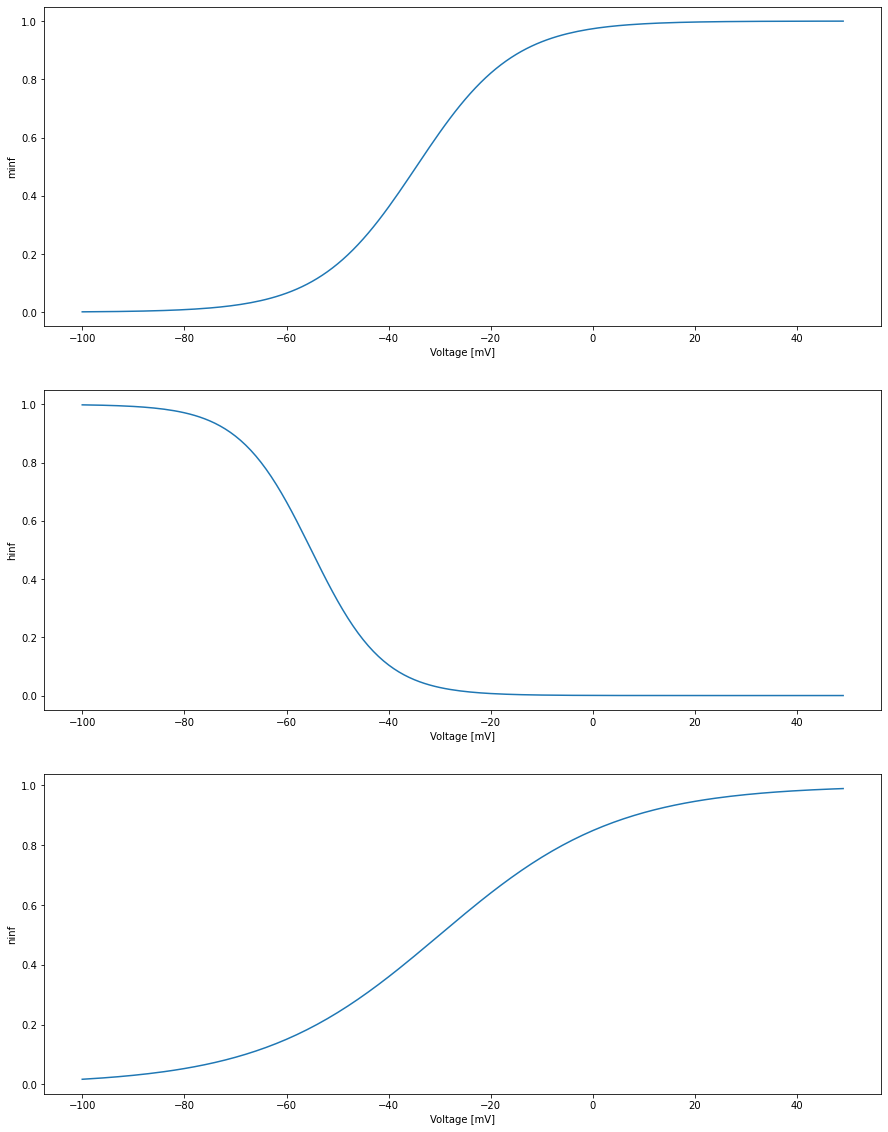

In [2]:
import matplotlib.pyplot as plt


fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

ax1.plot(Voltage, minf)
ax1.set_xlabel('Voltage [mV]')
ax1.set_ylabel('minf')

ax2.plot(Voltage, hinf)
ax2.set_xlabel('Voltage [mV]')
ax2.set_ylabel('hinf')

ax3.plot(Voltage, ninf)
ax3.set_xlabel('Voltage [mV]')
ax3.set_ylabel('ninf')


fig = plt.gcf()
fig.set_size_inches(15, 20)  # increase plot size

# WB Cell Simulation
##### We are now going to build a WB neuron and place a current clamp on it using a python toolkit: bmtk.
    
### Building the Cell

In [3]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =1    # We are creating only 1 WB cell

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', # RTMExcCell hoc definition
        morphology='blank.swc')

### Saving the Cell

In [4]:
net.build()
net.save_nodes(output_dir='network')

### Apply Current Clamp

In [5]:
current_amplitude = 1.0

import h5py

i_ext=[]
for i in range(100):
    i_ext.append(current_amplitude)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Build the Simulation Environment
This takes our saved features that we just made and creates simulation_config.json and circuit_config.json files. 

From these we can run our simulation (these files are already created so you don't need to run it).

In [6]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=100.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 file_current_clamp={              # Creates a step current from 500.ms to 1500.0 ms
                      "input_type": "file_current_clamp",
                      "module": "FileIClamp",
                      "input_file":"input/amps.h5",
                      "node_set":"network"
                 },
                 v_init=-66.5,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json'
                )

### Run the Simulation

In [7]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-03-10 16:23:25,566 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-03-10 16:23:25,632 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-03-10 16:23:25,636 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-03-10 16:23:25,648 [INFO] Running simulation for 100.000 ms with the time step 0.100 ms


C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:229: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if "gids" not in list(file.keys()) or file["gids"].value == 'all':
C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:243: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  amplitudes = file["amplitudes"].value
C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:248: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dts = file["dts"].value
INFO:NEURONIOUtils:Running simulation for 100.000 ms with the time step 0.100 ms


2021-03-10 16:23:25,650 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-03-10 16:23:25,652 [INFO] Block save every 1000 steps


INFO:NEURONIOUtils:Block save every 1000 steps


2021-03-10 16:23:25,685 [INFO]     step:1000 t_sim:100.00 ms


INFO:NEURONIOUtils:    step:1000 t_sim:100.00 ms


2021-03-10 16:23:25,697 [INFO] Simulation completed in 0.0485 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.0485 seconds 


### Display Results

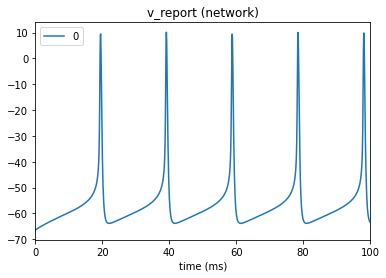

In [8]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='config.json', node_ids=[0], report_name='v_report')

As you can see, a spiking pattern arises similar to Borger's example